In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score

from catboost import CatBoostRegressor
import lightgbm as lgb

import pickle

In [ ]:
train=pd.read_csv("data/train.csv")
test=pd.read_csv("data/test.csv")
df1d=pd.concat([train,test]).sort_values("dt").reset_index(drop=True)

In [ ]:
df1d["dt"] = pd.to_datetime(df1d["dt"])
df1d["year"] = df1d["dt"].dt.year
df1d["month"] = df1d["dt"].dt.month
df1d["day"] = df1d["dt"].dt.day
df1d["week"] = df1d["dt"].dt.isocalendar().week

In [ ]:
df1d

In [ ]:
df1d.set_index("dt",inplace=True)

In [ ]:
for lag in [1,2,3,6,12]:
    df1d[f"lag_{lag}"]=df1d["Цена на арматуру"].shift(lag)
df1d=df1d.dropna()

In [ ]:
train_size=int(len(df1d)*0.8)
train,test=df1d.iloc[:train_size],df1d.iloc[train_size:]
# catboost на одномерной
X_train,y_train=train.drop(columns=["Цена на арматуру"]),train["Цена на арматуру"]
X_test,y_test=test.drop(columns=["Цена на арматуру"]),test["Цена на арматуру"]

In [ ]:
model=CatBoostRegressor(iterations=5000, 
                        learning_rate=0.01, 
                        depth=1, 
                        loss_function="MAE",
                        has_time=True,
                        early_stopping_rounds=100)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"MAE={mae:.2f}")
print(f"MAPE={mape:.2f}")
print(f"R²={r2:.4f}")

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(test.index,y_test,label="факт",color=(.647,.803,.566))
plt.plot(test.index,predictions,label="прогноз",color=(.147,.191,.446))
plt.title(f"прогноз цены на арматуру (CatBoost). MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.4f}")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
with open('1d_catboost.pkl', 'wb')as f:pickle.dump(model, f)

In [3]:
df=pd.read_csv("data/to-modal.csv",parse_dates=["dt"],index_col="dt")

In [4]:
for lag in [1,2,3,6,12]:
    df[f"lag_{lag}"]=df["Цена на арматуру"].shift(lag)
df=df.dropna()

In [5]:
train_size=int(len(df)*0.8)
train,test=df.iloc[:train_size],df.iloc[train_size:]
X_train,y_train=train.drop(columns=["Цена на арматуру"]),train["Цена на арматуру"]
X_test,y_test=test.drop(columns=["Цена на арматуру"]),test["Цена на арматуру"]

In [18]:
model=lgb.LGBMRegressor(n_estimators=500,
                        learning_rate=0.03,
                        max_depth=5,
                        random_state=42)
model.fit(X_train.values,y_train.values)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3268
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 52
[LightGBM] [Info] Start training from score 36075.271084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMRegressor(learning_rate=0.03, max_depth=5, n_estimators=500,
              random_state=42)

In [19]:
predictions=model.predict(X_test)
mae=mean_absolute_error(y_test,predictions)
mape=mean_absolute_percentage_error(y_test,predictions)
r2=r2_score(y_test,predictions)
print(f"MAE={mae:.2f}")
print(f"MAPE={mape:.2f}")
print(f"R²={r2:.4f}")

MAE=4242.59
MAPE=0.08
R²=0.7374


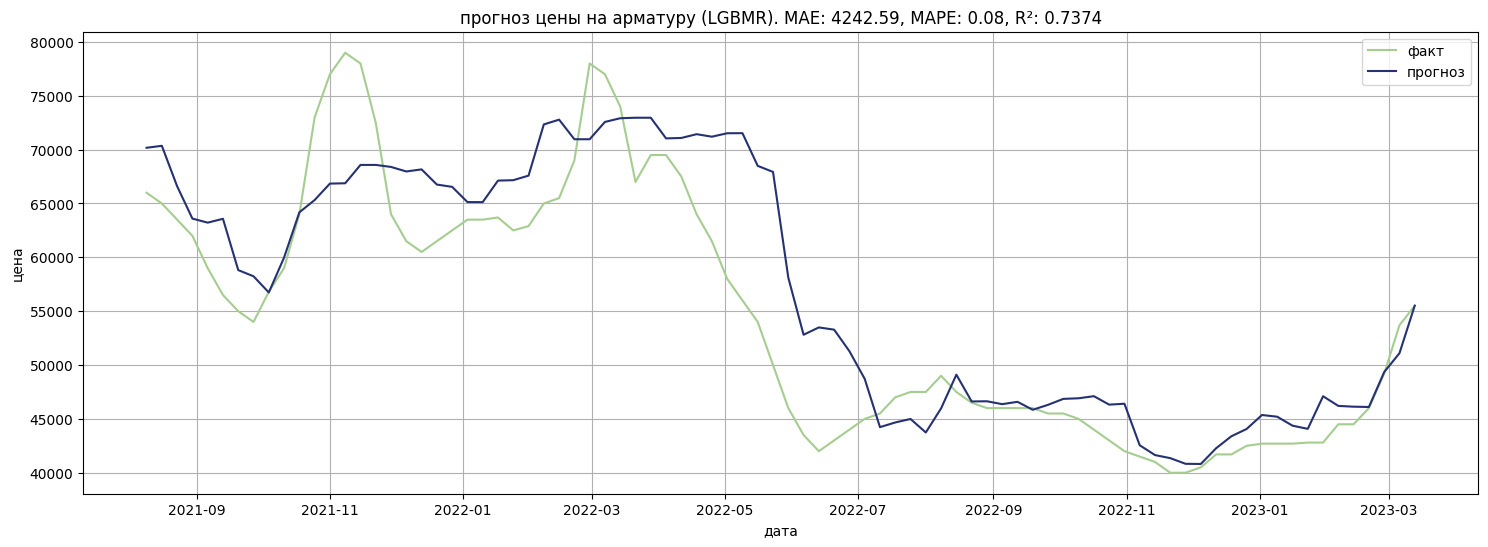

In [20]:
plt.figure(figsize=(18,6))
plt.plot(test.index,y_test,label="факт",color=(.647,.803,.566))
plt.plot(test.index,predictions,label="прогноз",color=(.147,.191,.446))
plt.title(f"прогноз цены на арматуру (LGBMR). MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.4f}")
plt.xlabel("дата")
plt.ylabel("цена")
plt.legend()
plt.grid()
plt.show()

In [52]:
feature_importance=model.feature_importances_
sorted_idx=np.argsort(feature_importance)[::-1]
top_n=15
top_feature_indices=sorted_idx[:top_n]
top_features=X_train.columns[top_feature_indices].tolist()
X_selected=X_train[top_features]
X_test_selected=X_test[top_features]
print("Топ-15 признаков:",top_features)
X_selected

Топ-15 признаков: ['Индекс стоимости грузоперевозок', 'ЖРС_Китай Iron ore fines Fe 62%, CFR', 'Лом_3А, FOB РФ Черное море, $/т', 'Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС', 'Чугун_CFR Италия, $/т', 'Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т', 'Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС', 'Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС', 'Чугун_FOB Бразилия Север, $/т', 'Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС', 'ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т', 'Лом_HMS 1/2 80:20, FOB США Восток, $/т', 'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС', 'Лом_HMS 1/2 80:20, CFR ЮВА, $/т', 'Концентрат коксующегося угля_Россия марка КС FCA руб./т, без НДС']


,Индекс стоимости грузоперевозок,"ЖРС_Китай Iron ore fines Fe 62%, CFR","Лом_3А, FOB РФ Черное море, $/т","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Чугун_CFR Италия, $/т","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Чугун_FOB Бразилия Север, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т","Лом_HMS 1/2 80:20, FOB США Восток, $/т","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","Лом_HMS 1/2 80:20, CFR ЮВА, $/т","Концентрат коксующегося угля_Россия марка КС FCA руб./т, без НДС"
dt,,,,,,,,,,,,,,,
2015-03-30,1000.0,55.0,221.0,11853.0,285.5,231.0,4050.0,4400.0,269.0,12521.0,63.5,233.0,12569.0,254.0,3750.0
2015-04-06,1000.0,50.0,229.0,11785.0,285.5,235.0,4050.0,4400.0,265.0,12395.0,58.0,236.0,12421.0,258.0,3750.0
2015-04-13,1000.0,48.0,229.0,11327.0,285.5,238.0,5200.0,5350.0,265.0,12220.0,57.5,236.0,12146.0,258.0,4400.0
2015-04-20,1000.0,50.0,238.0,11050.0,285.5,245.0,5200.0,5350.0,265.0,11830.0,58.5,241.0,11716.0,258.0,4400.0
2015-04-27,1000.0,54.0,243.0,11091.0,285.5,250.0,5200.0,5350.0,270.0,11083.0,61.0,248.0,11035.0,258.0,4400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-05,1175.0,218.0,460.0,25813.0,660.0,456.0,10500.0,11800.0,615.0,27776.0,259.0,459.0,27889.0,518.0,9500.0
2021-07-12,1182.0,220.0,458.0,25816.0,662.5,453.0,10500.0,11800.0,615.0,26909.0,260.0,457.0,27063.0,518.0,9500.0
2021-07-19,1170.0,220.0,448.0,25855.0,658.5,441.0,10500.0,11800.0,615.0,26080.0,255.0,448.0,25804.0,508.0,9500.0


In [60]:
important_model=lgb.LGBMRegressor(n_estimators=500,
                                  learning_rate=0.03,
                                  max_depth=5,
                                  random_state=42)
important_model.fit(X_selected.values,y_train.values)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 15
[LightGBM] [Info] Start training from score 36075.271084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMRegressor(learning_rate=0.03, max_depth=5, n_estimators=500,
              random_state=42)

In [61]:
predictions=important_model.predict(X_test_selected)

In [62]:
mae=mean_absolute_error(y_test,predictions)
mape=mean_absolute_percentage_error(y_test,predictions)
r2=r2_score(y_test,predictions)
print(f"MAE={mae:.2f}")
print(f"MAPE={mape:.2f}")
print(f"R²={r2:.4f}")

MAE=6370.94
MAPE=0.11
R²=0.4647


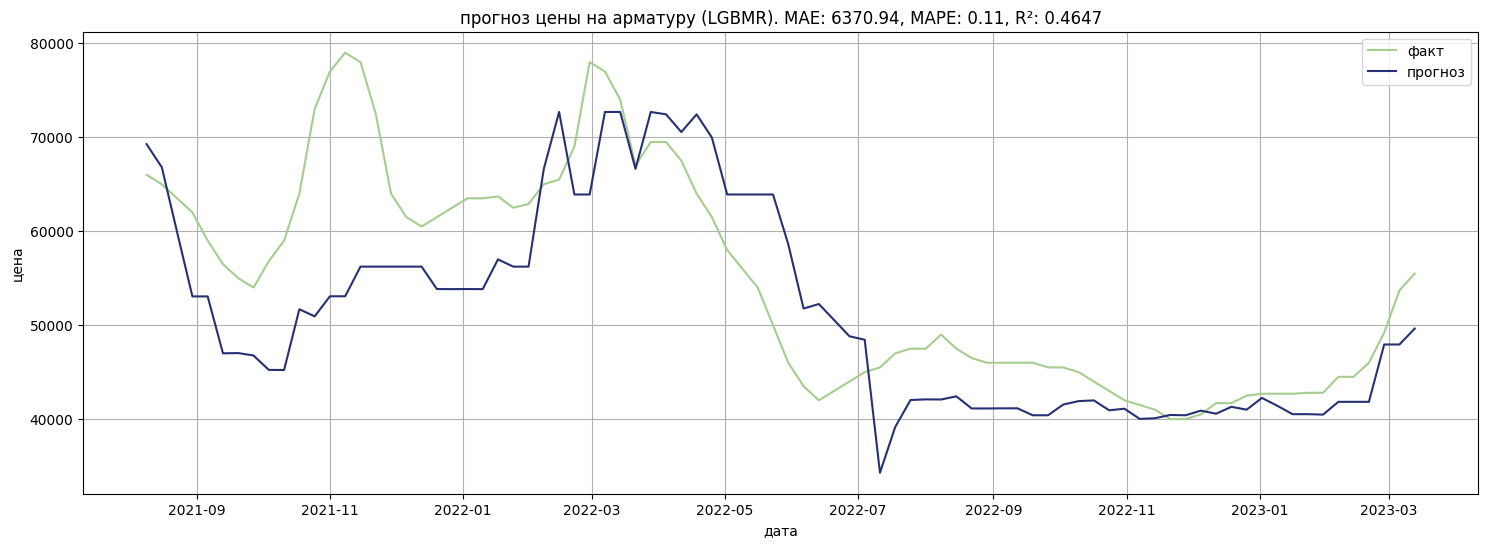

In [59]:
plt.figure(figsize=(18,6))
plt.plot(test.index,y_test,label="факт",color=(.647,.803,.566))
plt.plot(test.index,predictions,label="прогноз",color=(.147,.191,.446))
plt.title(f"прогноз цены на арматуру (LGBMR). MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.4f}")
plt.xlabel("дата")
plt.ylabel("цена")
plt.legend()
plt.grid()
plt.show()

In [63]:
with open('lgbm_model.pkl', 'wb') as f: pickle.dump(model, f)